<a href="https://colab.research.google.com/github/Stone-bridge-NLP/BERT/blob/main/GenreClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting environment

In [1]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 3.0 MB/s 
     |████████████████████████████████| 3.3 MB 5.2 MB/s 


In [3]:
# download shared dataset to local disk
# [차도인] [오후 9:37] https://drive.google.com/file/d/168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-/view?usp=sharing
!gdown --id 168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
FILENAME = 'preprocessed_train_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
To: /content/preprocessed_train_data.csv
100% 302M/302M [00:01<00:00, 192MB/s]


# Train model

In [4]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
train_dataset = pd.read_csv('/content/'+FILENAME)
print(train_dataset)

        Genre                                             Lyrics
0        Rock  it starts with pain followed by hate fueled by...
1        Rock  freedom alone again again alone patiently wait...
2        Rock  biting the hand that feeds you lying to the vo...
3        Rock  you say you know just who i am but you can t i...
4        Rock  my heart is beating faster can t control these...
...       ...                                                ...
249943    R&B  i m the best friend he s got i d give him the ...
249944    Pop  bad boys blue i totally miss you i did you wro...
249945    Pop  forgive me for the things that i never said to...
249946  Indie  the day they found a cure for aids the day the...
249947    Pop  fourth of july has come it s custom that we go...

[249948 rows x 2 columns]


In [6]:
# Balance sampling of the DATA.
# problem here is that some genre is oversampled too much(copied 11 times)
# another problem is that this samping happens during the runtime,
# so train set and validation set is mixed up every new runtime

genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
portion = len(train_dataset)//(10*12) # 10 classes, 1/12th of dataset
equal_td = []
train_dataset = train_dataset[['Genre', 'Lyrics']]
for genre in genre_id2name:
  td = train_dataset[train_dataset['Genre'] == genre]
  equal_td.append(td.sample(n=portion,replace=True))
  print(f'{genre}\t sample ratio\t {len(td)}:{portion}')
  
td = pd.concat(equal_td).reset_index().drop(columns=['index'])

Electronic	 sample ratio	 2002:2082
Country	 sample ratio	 1890:2082
R&B	 sample ratio	 2763:2082
Jazz	 sample ratio	 13314:2082
Indie	 sample ratio	 7240:2082
Pop	 sample ratio	 86217:2082
Folk	 sample ratio	 8165:2082
Metal	 sample ratio	 19098:2082
Hip-Hop	 sample ratio	 2238:2082
Rock	 sample ratio	 107016:2082


In [7]:
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      
      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      sg_tensor = torch.tensor(indexed_tokens['token_type_ids']).view(-1,2**9)
      at_tensor = torch.tensor(indexed_tokens['attention_mask']).view(-1,2**9)

    return genre, tk_tensor, sg_tensor, at_tensor



In [8]:
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, n_class, dropout):
    super(TextLSTM, self).__init__()

    self.hidden_size = hidden_size

    self.lstm1 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*5,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm2 = nn.LSTM(
              input_size=hidden_size*5,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm3 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, X, seq_len):
    # X of shape N,L,Hin
    # hidden_and_cell zeros by default
    # outputs of shape N,L,Hout

    outputs, hidden_and_cell = self.lstm1(X)
    outputs, hidden_and_cell = self.lstm2(outputs)
    seq_len = torch.tile(seq_len.view(batch_size,1,1),(1,1,self.hidden_size))
    outputs = torch.gather(outputs,1,seq_len)
    outputs = outputs[:,-1]  # last hidden Layer of shape N,Hout
    return self.dense(outputs) # return of shape N,n_class

In [9]:
def save_checkpoint(current_epoch, model, PATH):
  torch.save({
      'current_epoch':current_epoch,
      'model':model.state_dict()
  }, PATH)

In [14]:
#### hyperparameters ####
epoch = 20
lr = 0.001
batch_size = 128
num_sentences = 1 # one sentence has 512 tokens
hidden_size = 128
num_layers = 1
dropout = 0.3
save_epoch = 1
save_path = 'checkpoint.pth'
epoch_start = 0

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [15]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)


dset = LyricsAndGenreDataset(td,tokenizer,num_sentences)
split_size = [
              int(0.8*len(dset)),
              len(dset)-int(0.8*len(dset))]
# train_set, val_set = torch.utils.data.random_split(dset,split_size)

train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)

# load model if possible
try:
  cp = torch.load(save_path)
  epoch_start= cp['current_epoch']+1
  lstm_classifier.load_state_dict(cp['model'])
except FileNotFoundError:
  print('no savefile to load')

loss_func = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

In [16]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []


for e in range(epoch_start, epoch, 1):
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

    embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)
    #print(embedded_tokens[:,-1])

    output = lstm_classifier.forward(embedded_tokens, seq_len)

    optimizer.zero_grad()
    loss = loss_func(output, label_batch)
    loss.backward()
    optimizer.step()
    
    if b%4 == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))

      print(f'\rTRAIN: epoch {e} batch {b}\
       loss {train_loss_list[-1]}\t acc {train_acc_list[-1]}', end='\t')

  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

      embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

      output = lstm_classifier.forward(embedded_tokens, seq_len)

      optimizer.zero_grad()
      loss = loss_func(output, label_batch)
    

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    print(f'\rVAL: epoch {e} batch {b}\
       loss {val_loss_list[-1]}\t acc {val_acc_list[-1]}', end='\t')

  if e%save_epoch == 0:
    save_checkpoint(e,lstm_classifier,save_path)

VAL: epoch 19 batch 31       loss 1.9562441110610962	 acc 0.5	

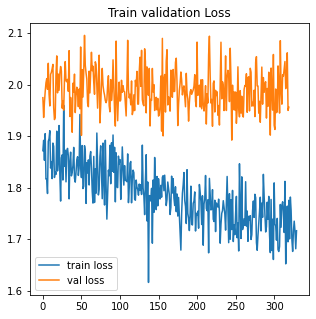

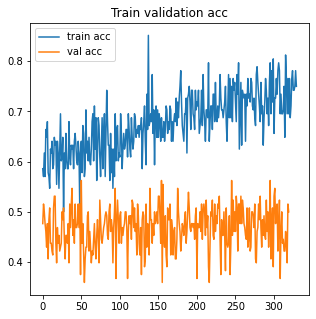

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('Train validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.title('Train validation acc')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()